In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
def plotar_conexoes(a):
    node_radius = 0.15 
    n = len(a)
    for servidor in range(n):
        plt.figure(figsize=(8, 3))
        for i in range(n):
            plt.plot(i, 0, 'o', markersize=30, color='lightblue') 
            plt.text(i, 0, str(i), ha='center', va='center', fontweight='bold')
        for destino in range(n):
            peso = a[servidor][destino]
            if peso == 0:
                continue
            cor = 'green' if peso > 0 else 'red' 
            if servidor == destino:
                plt.annotate(
                    "",
                    xy=(servidor, 0),
                    xytext=(servidor, 0),
                    arrowprops=dict(
                        arrowstyle='->',
                        color=cor,
                        shrinkA=0,
                        shrinkB=0,
                        connectionstyle="arc3,rad=0.3",
                        lw=2
                    )
                )
                plt.text(servidor, 0.25, str(peso), ha='center', color=cor, 
                         bbox=dict(facecolor='white', edgecolor='none', pad=2))
            else:
                plt.annotate(
                    "",
                    xytext=(servidor + node_radius, 0),
                    xy=(destino - node_radius, 0), 
                    arrowprops=dict(
                        arrowstyle='->',
                        color=cor,
                        lw=2,
                        shrinkA=0,
                        shrinkB=0
                    )
                )
                pos_x = (servidor + destino) / 2
                if servidor == 0 and destino > 1:
                    pos_x += 0.4
                elif servidor > 1 and destino > servidor:
                    pos_x -= 0.4
                elif destino < n - 2 and servidor == n - 1:
                    pos_x -= 0.4
                elif destino == n - 1 and servidor == n - 1:
                    pos_x += 0.2
                offset = 0.15 if servidor < destino else -0.15
                plt.text(pos_x, offset, str(peso), ha='center', color=cor,
                         bbox=dict(facecolor='white', edgecolor='none', pad=2))
        
        plt.title(f'Conexões do Servidor {servidor}', fontsize=12, pad=2)
        plt.xlim(-0.5, n - 0.5)
        plt.ylim(-0.5, 0.5)
        plt.axis('off')
        plt.show()

In [3]:
def plot_graph(A):
    G = nx.DiGraph()
    num_servers = len(A)
    for i in range(num_servers):
        G.add_node(f"S{i+1}", carga=A[i][i])
        for j in range(num_servers):
            if j != i and A[i][j] != 0:
                G.add_edge(f"S{i+1}", f"S{j+1}")
    pos = nx.spring_layout(G)
    labels = {node: f"{node}\n{G.nodes[node]['carga']}" for node in G.nodes}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    plt.title("Representação Gráfica dos Servidores")
    plt.show()

In [4]:
def eliminacao_gauss(A, b, max_iter):
    # Conversão para ponto flutuante
    n = len(A)
    for i in range(n):
        for j in range(n):
            A[i][j] = float(A[i][j])
        b[i] = float(b[i])
    # Eliminação de Gauss com pivotamento parcial
    for i in range(n):
        max_index = max(range(i, n), key=lambda k: abs(A[k][i]))
        if A[max_index][i] == 0:
            raise ValueError(f"A matriz é singular, não é possível resolver o sistema para a linha {i}.")
        if max_index != i:
            A[i], A[max_index] = A[max_index], A[i]
            b[i], b[max_index] = b[max_index], b[i]
        for k in range(i + 1, n):
            fator = A[k][i] / A[i][i]
            for j in range(i, n):
                A[k][j] -= fator * A[i][j]
            b[k] -= fator * b[i]
    # Substituição regressiva
    x = [0] * n
    for i in range(n - 1, -1, -1):
        soma = sum(A[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (b[i] - soma) / A[i][i]
    # Refinamento iterativo
    for _ in range(max_iter):
        r = [b[i] - sum(A[i][j] * x[j] for j in range(n)) for i in range(n)]
        delta_x = [0] * n
        for i in range(n - 1, -1, -1):
            soma = sum(A[i][j] * delta_x[j] for j in range(i + 1, n))
            delta_x[i] = (r[i] - soma) / A[i][i]
        x = [x[i] + delta_x[i] for i in range(n)]
    
    return x

In [5]:
def metodo_jacobi(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    x_novo = x[:]
    for _ in range(max_iter):
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x_novo[i] = (b[i] - soma) / A[i][i]
        if max(abs(x_novo[i] - x[i]) for i in range(n)) < tol:
            return x_novo
        x = x_novo[:]
    return x_novo

In [6]:
def metodo_gauss_seidel(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    for _ in range(max_iter):
        x_old = x[:]
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x[i] = (b[i] - soma) / A[i][i]
        if max(abs(x[i] - x_old[i]) for i in range(n)) < tol:
            return x
    return x

In [7]:
def analisar_variacao(A, b, max_iteracoes, func):
    solucoes = []
    iteracoes = list(range(1, max_iteracoes + 1))
    
    for i in iteracoes:
        solucoes.append(func(A, b, i))
    
    solucoes = np.array(solucoes)
    
    for i in range(len(A)):
        plt.figure(figsize=(8, 5))
        plt.plot(iteracoes, solucoes[:, i], marker='o', linestyle='-', label=f'x{i+1}')
        plt.xlabel('Número de Iterações')
        plt.ylabel('Valor da Solução')
        plt.title(f'Variação da Solução para x{i+1}')
        plt.legend()
        plt.grid()
        plt.show()

In [24]:
A = [
[400, -1, -1, 0, 0, 0],
[-1, 400, 0, 0, 0, 0],
[-1, 0, 400, -1, -1, -1],
[0, 0, -1, 400, 0, 0],
[0, 0, -1, 0, 400, 0],
[0, 0, -1, 0, 0, 400]
]
b = [500, 300, 700, 350, 400, 500]

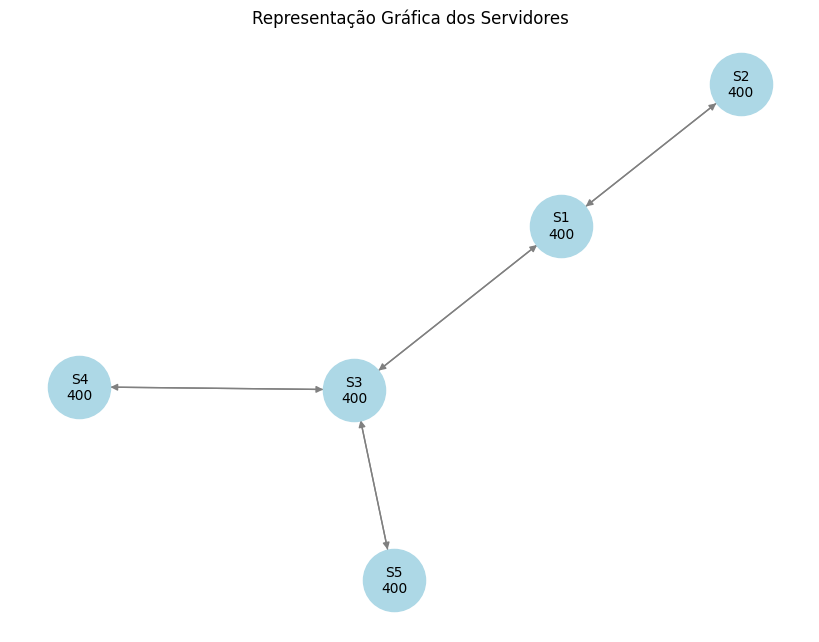

In [25]:
plot_graph(A)

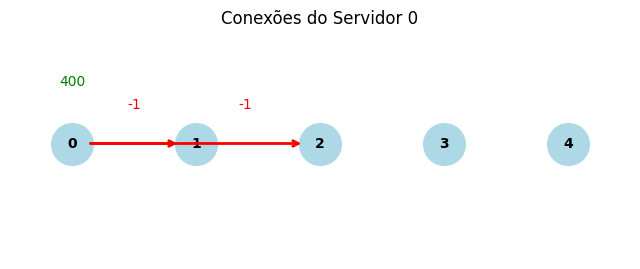

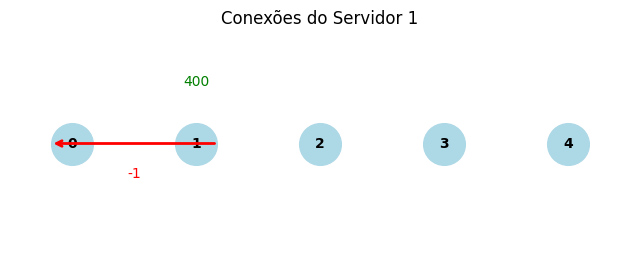

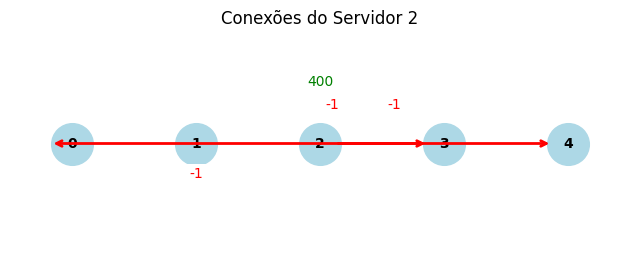

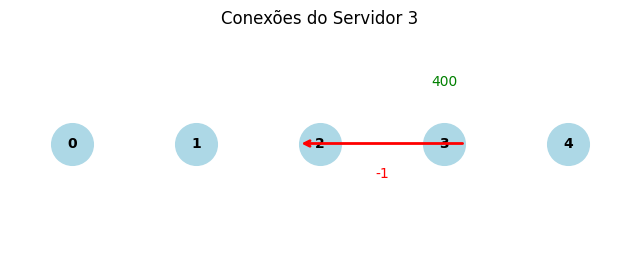

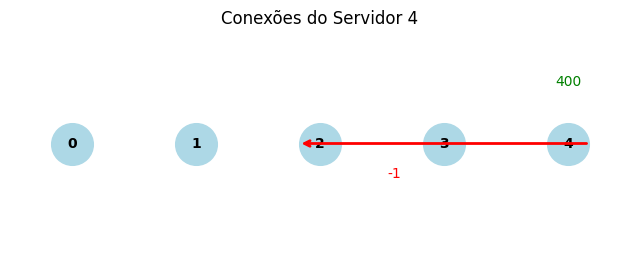

In [26]:
plotar_conexoes(A)

Solução do sistema: [1.2562774771512821, 0.7531406936928782, 1.7578501668199635, 0.8793946254170498, 1.00439462541705]


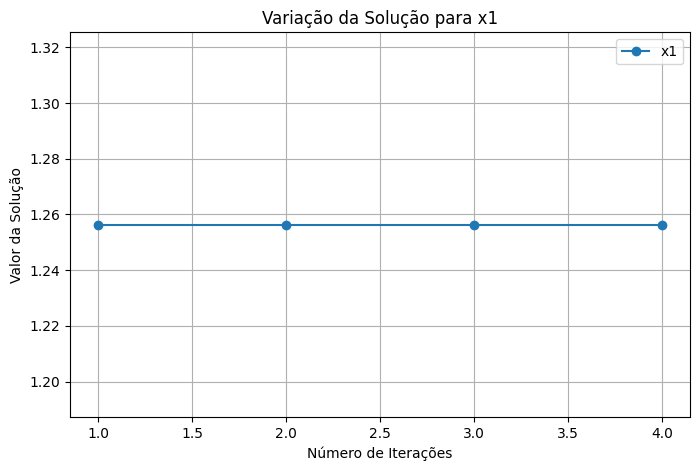

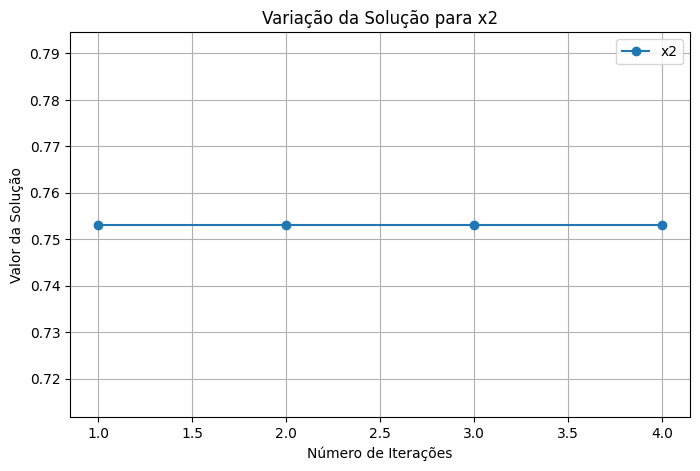

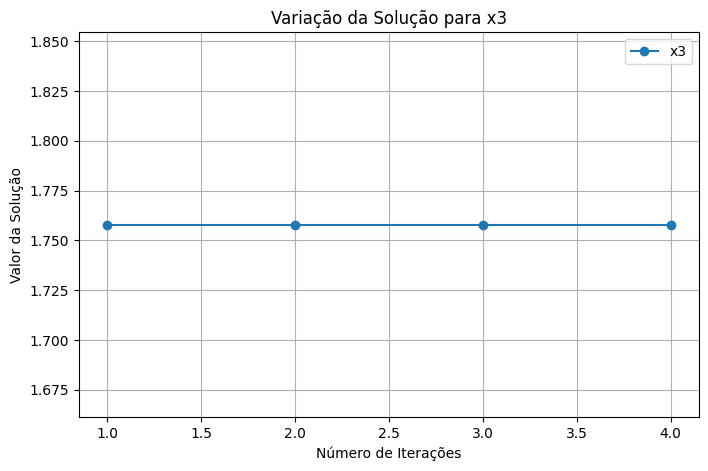

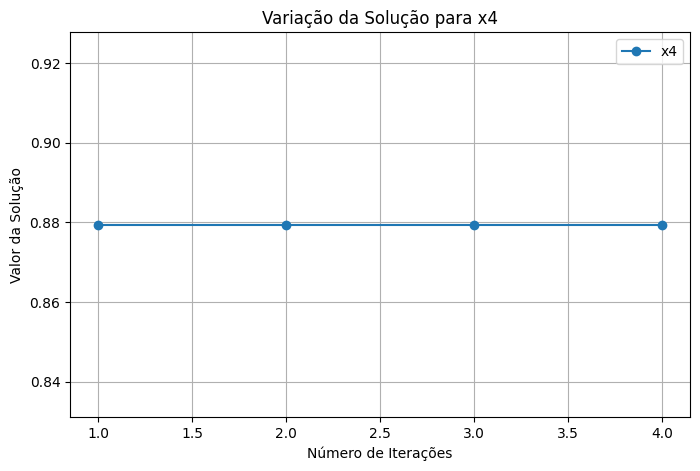

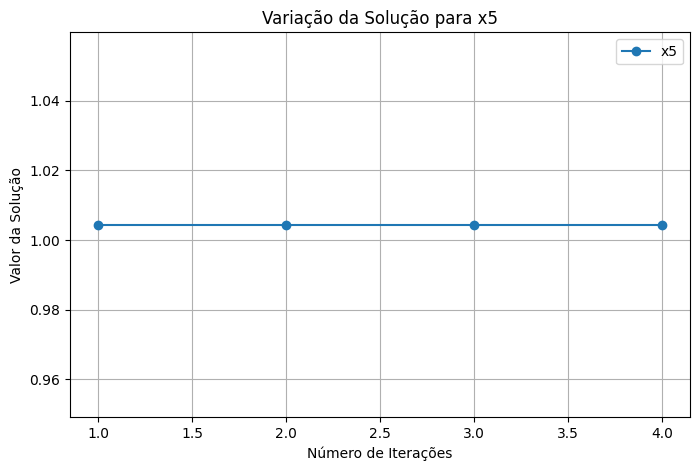

In [27]:
print("Solução do sistema:", eliminacao_gauss(A, b, 1))
analisar_variacao(A, b, 4, eliminacao_gauss) 

Solução pelo método de Jacobi: [1.2544102585079495, 0.7531360256465758, 1.0109674812870701, 0.8775274187032179, 1.0025274187032178, 1.2525274187032178]


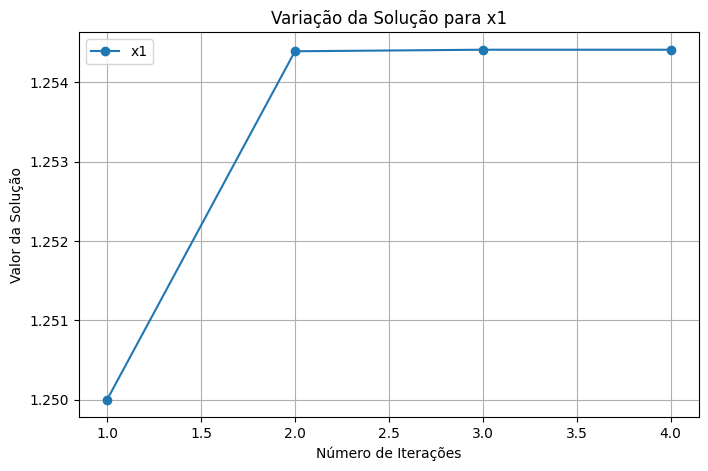

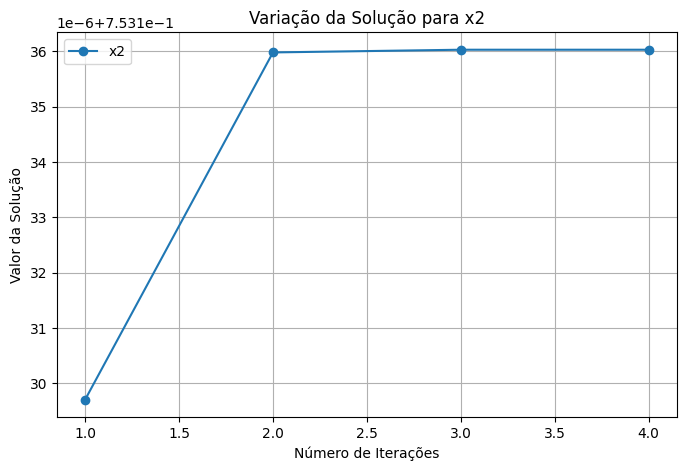

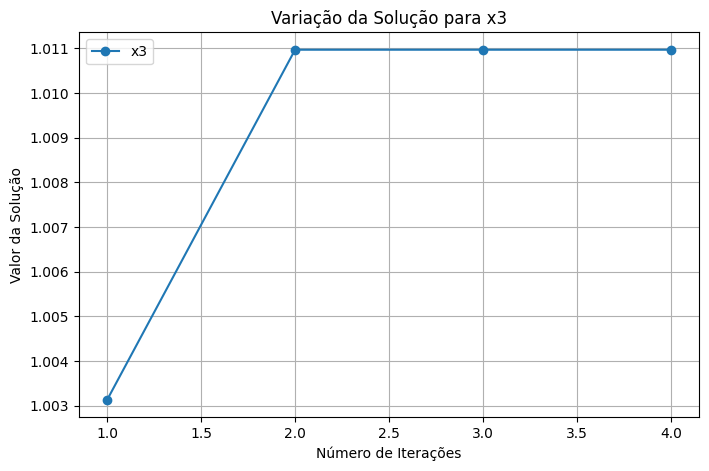

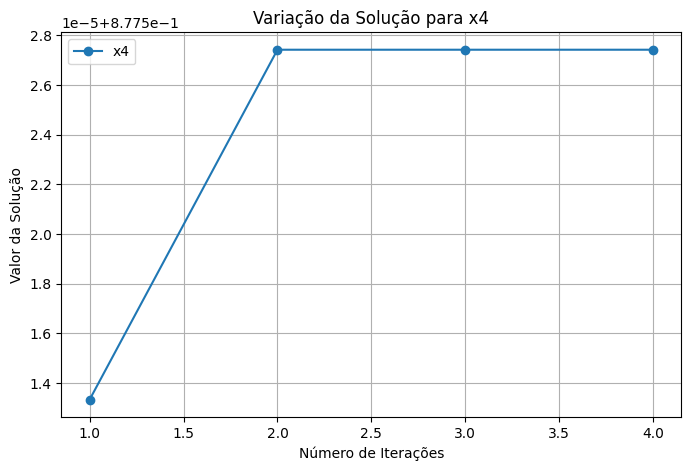

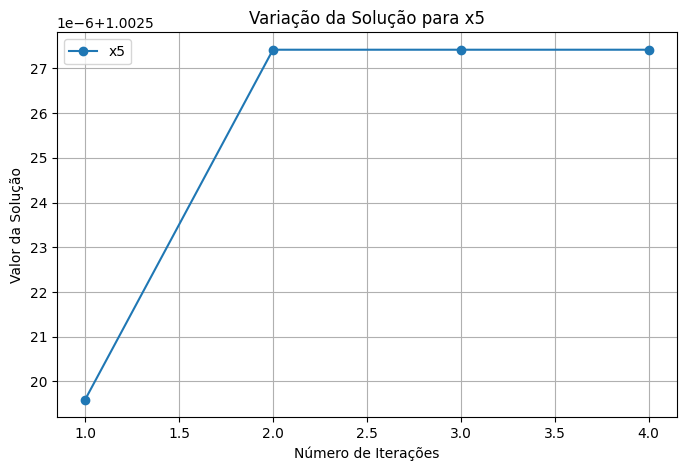

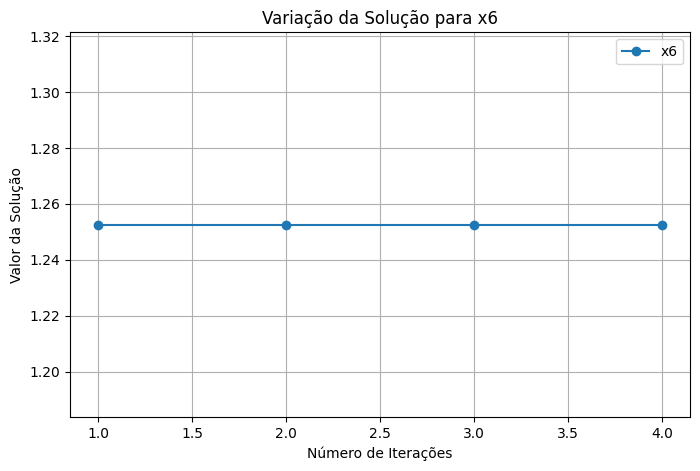

In [18]:
print("Solução pelo método de Jacobi:", metodo_jacobi(A, b, 3))
analisar_variacao(A, b, 4, metodo_jacobi) 

Solução pelo método de Gauss-Seidel: [1.254390664209401, 0.7531359766997088, 1.0109674264800697, 0.8775274186542895, 1.0025274187032178, 1.2525274187032178]


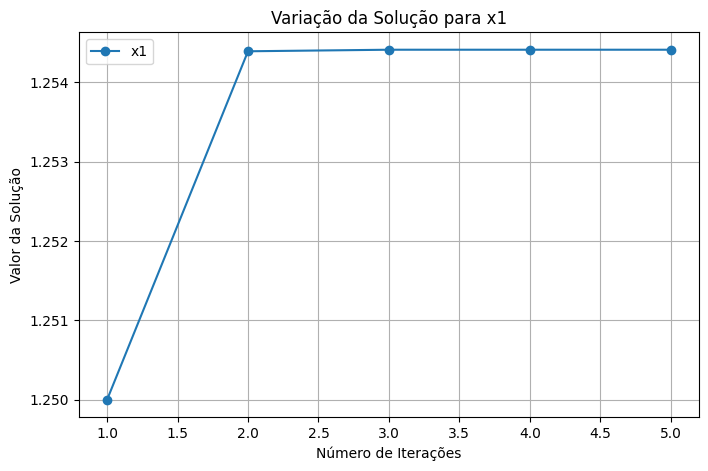

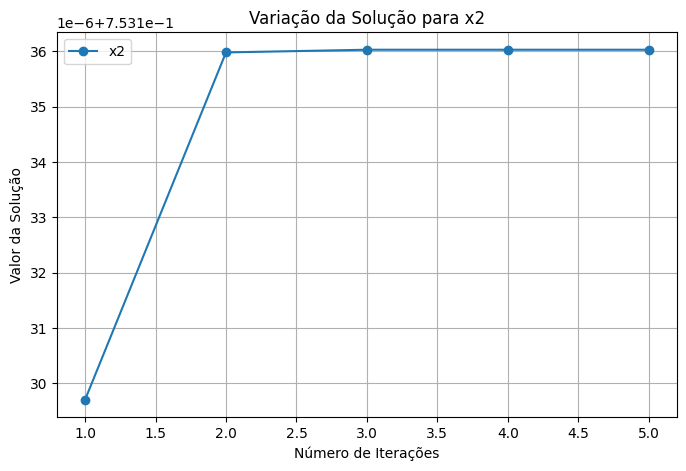

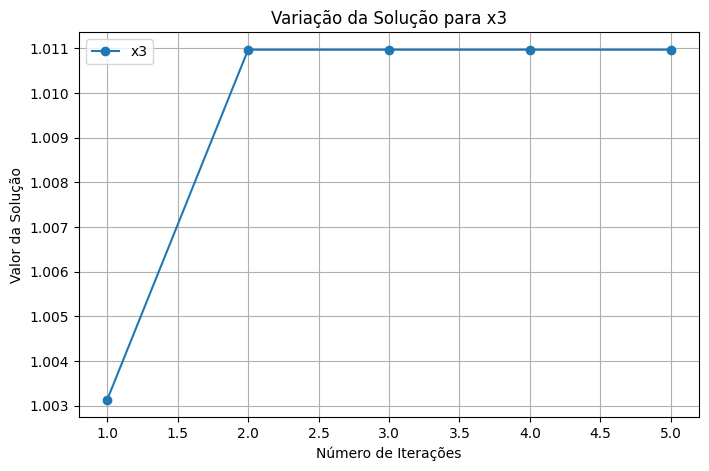

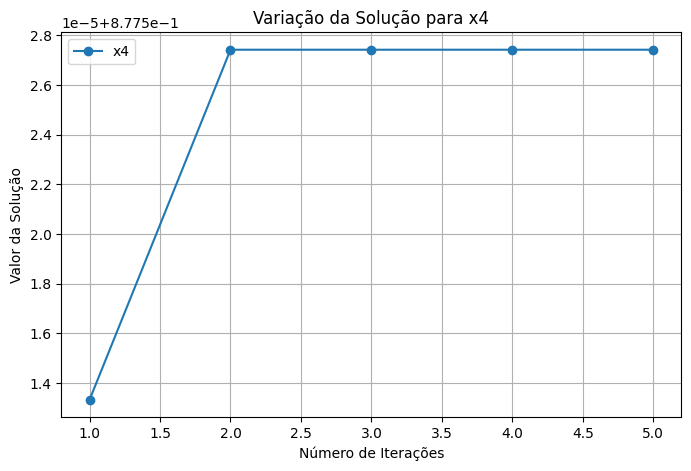

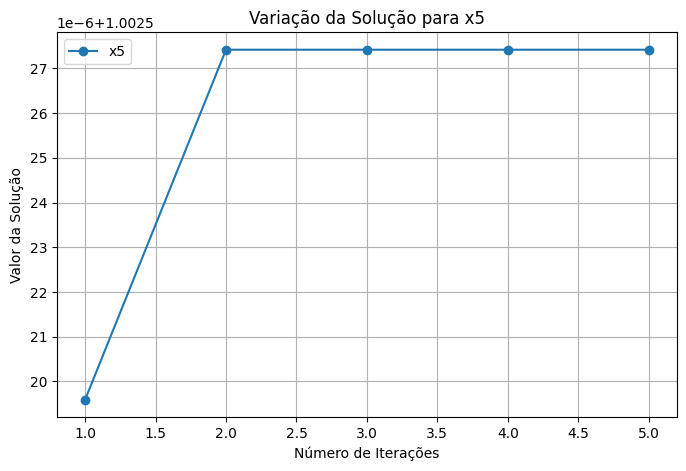

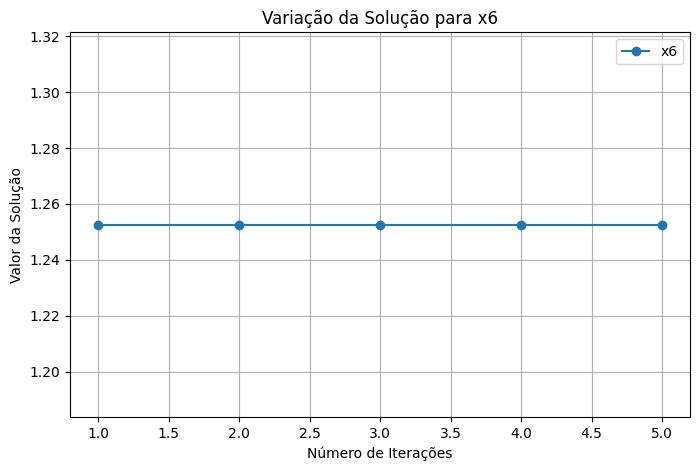

In [19]:
print("Solução pelo método de Gauss-Seidel:", metodo_gauss_seidel(A, b, 2))
analisar_variacao(A, b, 5, metodo_gauss_seidel) 